In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [31]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [32]:
file_path = '/content/drive/My Drive/data/hanoi_quality.csv'
n_in = 30
n_out = 1
ratio = 0.9
title = "MLP Model PM2.5 Forecast for Next 90 Days: Ha Noi - 9:1"

In [33]:
def smoothed(data):
    # Apply moving average filter to smooth the forecasted values
    window_size = 5
    forecast_smoothed = data.rolling(window=window_size).mean()

    # Interpolate NaN values resulting from the moving average
    forecast_smoothed_interpolated = forecast_smoothed.interpolate()

    # Fill remaining NaN values
    forecast_smoothed_filled = forecast_smoothed_interpolated.fillna(method='bfill')
    return forecast_smoothed_filled

In [34]:
# Đọc và chuẩn bị dữ liệu
def prep_data_pm25(file_path):
    # Đọc dữ liệu từ file CSV
    df = pd.read_csv(file_path, parse_dates=['date'], dayfirst=True)
    df.drop(columns=['date'], inplace=True)

    df = smoothed(df)

    # Chuẩn bị dữ liệu theo định dạng của mô hình
    input_t = n_in
    output_t = n_out
    cols = []
    names = []

    for i in range(input_t, 0, -1):
        cols.append(df['pm25'].shift(i))
        names.append(f't-{i}')
    for i in range(0, output_t):
        cols.append(df['pm25'].shift(-i))
        names.append(f't+{i}')

    n_df = pd.concat(cols, axis=1)
    n_df.columns = names
    n_df.dropna(inplace=True)

    X = n_df.iloc[:, :-1]
    Y = n_df.iloc[:, -1]

    factor = int(ratio * len(X))

    X_train = X[:factor]
    Y_train = Y[:factor]
    X_test = X[factor:]
    Y_test = Y[factor:]

    return X_train, Y_train, X_test, Y_test, df

In [35]:
# Chuẩn bị dữ liệu
X_train, Y_train, X_test, Y_test, df = prep_data_pm25(file_path)

In [36]:
# Định nghĩa mô hình
clf = MLPRegressor(hidden_layer_sizes=(900, 7), activation='relu',
                   solver='adam', alpha=0.001, batch_size=13,
                   learning_rate='constant', learning_rate_init=0.001,
                   max_iter=1000, shuffle=True, random_state=5, tol=0.001,
                   early_stopping=False, verbose=True)

In [37]:
# Huấn luyện mô hình
clf.fit(X_train, Y_train)

Iteration 1, loss = 195.18469394
Iteration 2, loss = 64.98497921
Iteration 3, loss = 48.35532716
Iteration 4, loss = 42.05716526
Iteration 5, loss = 34.88607065
Iteration 6, loss = 31.54179024
Iteration 7, loss = 38.92437581
Iteration 8, loss = 31.80356619
Iteration 9, loss = 26.45936994
Iteration 10, loss = 28.57237872
Iteration 11, loss = 27.74522984
Iteration 12, loss = 29.53304479
Iteration 13, loss = 28.89124114
Iteration 14, loss = 30.92815719
Iteration 15, loss = 22.98090162
Iteration 16, loss = 21.87950404
Iteration 17, loss = 24.43630849
Iteration 18, loss = 23.32949192
Iteration 19, loss = 27.51955966
Iteration 20, loss = 25.56732153
Iteration 21, loss = 21.55108172
Iteration 22, loss = 22.15830260
Iteration 23, loss = 23.53170763
Iteration 24, loss = 23.37257308
Iteration 25, loss = 23.72410673
Iteration 26, loss = 20.97670878
Iteration 27, loss = 20.82278732
Iteration 28, loss = 22.45477027
Iteration 29, loss = 23.34251146
Iteration 30, loss = 20.17119175
Iteration 31, loss

MLPRegressor(alpha=0.001, batch_size=13, hidden_layer_sizes=(900, 7),
             max_iter=1000, random_state=5, tol=0.001, verbose=True)

In [38]:
# Đánh giá mô hình
pred = clf.predict(X_test)

In [39]:
rmse = np.sqrt(mean_squared_error(Y_test, pred))
mae = mean_absolute_error(Y_test, pred)
mape = calculate_mape(Y_test, pred)

In [40]:
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)

RMSE: 8.439441608918447
MAE: 6.506900425533606
MAPE: 7.297951506211953


In [41]:
# Dự đoán 90 ngày trong tương lai
last_ins_days = X_test.iloc[-1].values
future_preds = []

for i in range(90):
    next_pred = clf.predict([last_ins_days])[0]
    future_preds.append(next_pred)
    last_ins_days = np.roll(last_ins_days, -1)
    last_ins_days[-1] = next_pred

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegress

In [42]:
Y_train = pd.concat([df['pm25'].head(n_in), Y_train])

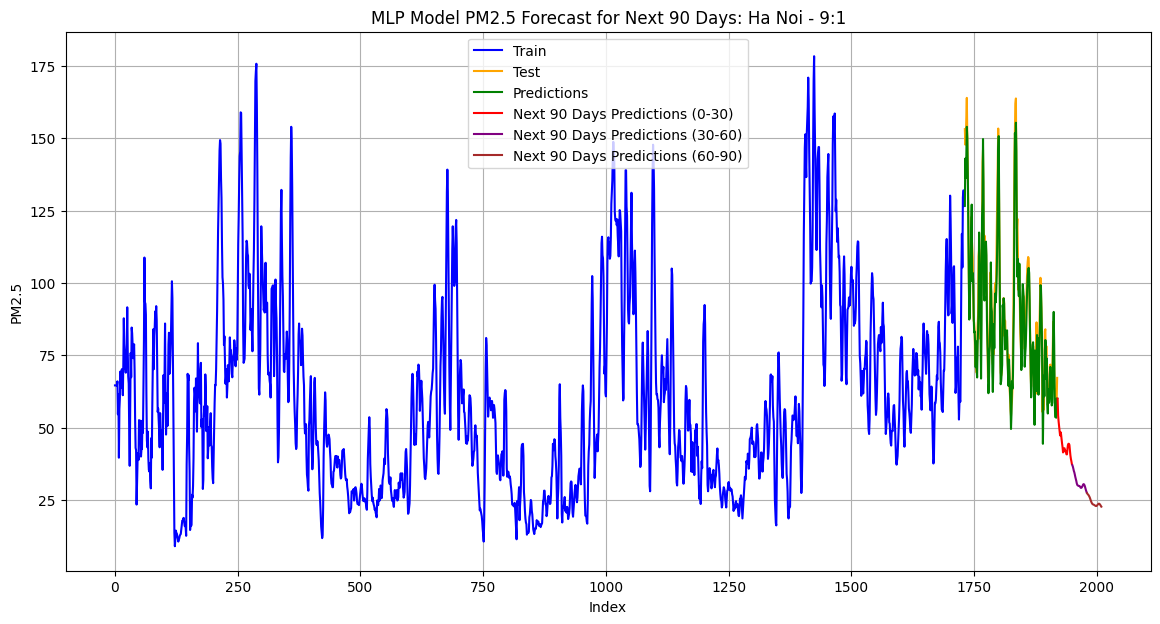

In [43]:
# Tạo index cho các dự đoán 90 ngày tương lai
future_index = np.arange(len(df), len(df) + 90)

# Vẽ đồ thị
plt.figure(figsize=(14, 7))

# Đường huấn luyện
plt.plot(np.arange(len(Y_train)), Y_train, label='Train', color='blue')

# Đường kiểm tra
plt.plot(np.arange(len(Y_train), len(Y_train) + len(Y_test)), Y_test, label='Test', color='orange')

# Đường dự đoán
plt.plot(np.arange(len(Y_train), len(Y_train) + len(pred)), pred, label='Predictions', color='green')

# Đường dự đoán 90 ngày tương lai (chia thành ba đoạn)
plt.plot(future_index[:30], future_preds[:30], label='Next 90 Days Predictions (0-30)', color='red')
plt.plot(future_index[30:60], future_preds[30:60], label='Next 90 Days Predictions (30-60)', color='purple')
plt.plot(future_index[60:90], future_preds[60:90], label='Next 90 Days Predictions (60-90)', color='brown')

plt.xlabel('Index')
plt.ylabel('PM2.5')
plt.title(title)
plt.legend()
plt.grid(True)
plt.show()


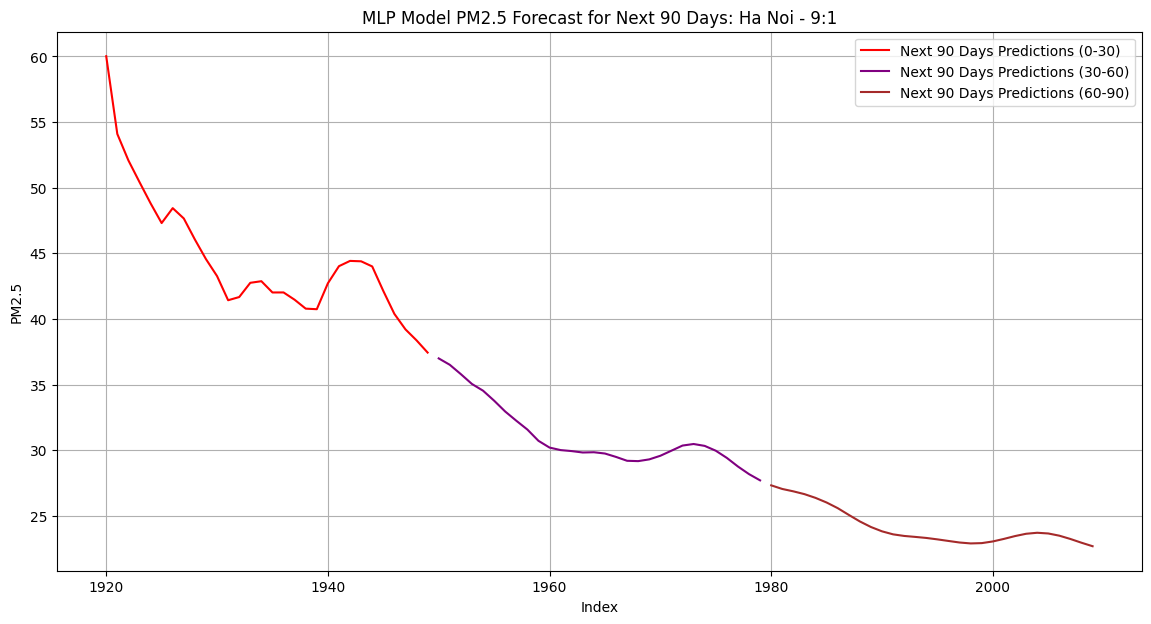

In [44]:
# Tạo index cho các dự đoán 90 ngày tương lai
future_index = np.arange(len(df), len(df) + 90)

# Vẽ đồ thị
plt.figure(figsize=(14, 7))

# Đường dự đoán 90 ngày tương lai (chia thành ba đoạn)
plt.plot(future_index[:30], future_preds[:30], label='Next 90 Days Predictions (0-30)', color='red')
plt.plot(future_index[30:60], future_preds[30:60], label='Next 90 Days Predictions (30-60)', color='purple')
plt.plot(future_index[60:90], future_preds[60:90], label='Next 90 Days Predictions (60-90)', color='brown')

plt.xlabel('Index')
plt.ylabel('PM2.5')
plt.title(title)
plt.legend()
plt.grid(True)
plt.show()
